# Introduction

The Monty Hall Problem is something of a cultural phenomenon. The problem reveals that our intuition can often fail us on even simple problems. Many often struggle to understand the solution even after a thorough explanation, and an understanding of statistics is often needed. In this notebook, I hope to demonstrate the solution in a more practical and accessible way.

# Description of the Problem

The Monty Hall Problem has it's origin in the game show "Let's Make a Deal". A contestant would be asked to chose one of three doors behind which are two goats and a car. Once the contestant had made their choice, the host would open one of the doors to reveal a goat. The contestant would then be asked if they wanted to stay with their original choice or switch to the other unopened door.

When first presented the problem, an overwhelming amount of people believe that that its a 50/50 chance of winning the car between staying and switching. Even Paul Erdős (of the famous "Erdos Number") remained unconvinced until presented a computer simulation of the problem. Reading this was what inspired this short notebook.

# Demonstration

In [96]:
import random
import pandas as pd
import numpy as np
from pandas.plotting import scatter_matrix
import matplotlib.pyplot as plt
from sklearn import model_selection
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix

In [22]:
def setting_up_the_doors():
    # decide the car door
    door_list = ["goat", "goat", "goat"]
    chosen_door = random.randint(0,2)
    door_list[chosen_door] = "car"
    return door_list   

In [23]:
def choose_a_door(door_list):
    chosen_door = random.randint(0,2)
    door_contains = door_list[chosen_door]

    return chosen_door

In [24]:
def reveal_goat(door_list, chosen_door):
    doors_with_goats = get_doors_with_goats(door_list)
    revealed_door = random.choice(doors_with_goats)
       
    if revealed_door == chosen_door:
        doors_with_goats.remove(revealed_door)
        revealed_door = doors_with_goats[0]
    
    return revealed_door

In [25]:
def get_doors_with_goats(door_list):
    doors_with_goats = [i for i, x in enumerate(door_list) if x == "goat"]
    return doors_with_goats

In [26]:
def switch(door_list, chosen_door, revealed_doors):
    doors_with_goats = get_doors_with_goats(door_list)
    door_numbers = [0,1,2]
    door_numbers.remove(chosen_door)
    door_numbers.remove(revealed_door)
    
    chosen_door = door_numbers[0]
    
    return chosen_door

In [27]:
def assess_win(door_list, chosen_door):
    win = 0
    if (door_list[chosen_door]=='car'):
        win = 1
        
    return win

## Game Setup

In [28]:
doors = setting_up_the_doors()
chosen_door = choose_a_door(doors)
print("Door No.{} was chosen".format(chosen_door+1))
revealed_door = reveal_goat(doors, chosen_door)
print("Door No.{} was revealed to have a goat".format(revealed_door+1))

Door No.3 was chosen
Door No.1 was revealed to have a goat


## Staying

In [29]:
print("You chose to stay with your choice")
if assess_win(doors, chosen_door) == 1:
    print("You win")
else:
    print ("you lose")

You chose to stay with your choice
You win


## Switching

In [31]:
print("You chose to switch your choice")
switch_choice = switch(doors, chosen_door, revealed_door)
if assess_win(doors, switch_choice) == 1:
    print("You win")
else:
    print ("you lose")

You chose to switch your choice
You win


# Test

Now let's show the solution by running many Monty Hall Problems

## Visualisation of Results

In [30]:
numbers_of_games = 100
stay_win = 0
switch_win = 0
win_list = []

for x in range(numbers_of_games):
    doors = setting_up_the_doors()
    chosen_door = choose_a_door(doors)
    revealed_door = reveal_goat(doors, chosen_door)
    
    if assess_win(doors, chosen_door) == 1:
        win_list.append(0)
    else:
        win_list.append(1)     

print("The results are staying: {}% and switching: {}%".format(round(win_list.count(0)/numbers_of_games*100), round(win_list.count(1)/numbers_of_games*100)))

The results are staying: 27% and switching: 73%


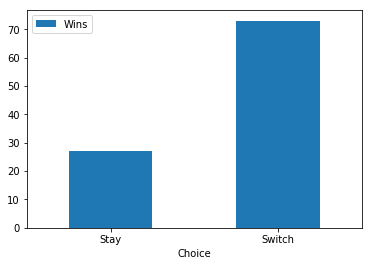

In [32]:
df = pd.DataFrame({'Choice':['Stay', 'Switch'], 'Wins':[win_list.count(0), win_list.count(1)]})
ax = df.plot.bar(x='Choice', y='Wins', rot=0)

# Machine Learning

## Creating a Dataset

In [79]:
dataset = pd.DataFrame(columns=['Game', 'Chosen_Door', 'Revealed_Door', 'Action', 'Outcome'])

We will now run 500 games and randomly choose to saty or switch. We will record the data in a DataFrame.

In [80]:
numbers_of_games = 500
game = 0

for x in range(numbers_of_games):
    action = 0
    game += 1
    doors = setting_up_the_doors()
    chosen_door = choose_a_door(doors)
    revealed_door = reveal_goat(doors, chosen_door)
    
    chosen_action = random.randint(0,1)
    
    if chosen_action == 1:
        chosen_door = switch(doors, chosen_door, revealed_door)
        action = 1
        
    if assess_win(doors, chosen_door) == 1:
        outcome = 'win'
    else:
        outcome = 'lose'   

    dataset = dataset.append({'Game': game, 'Chosen_Door': chosen_door, 'Revealed_Door': revealed_door, 'Action': action, 'Outcome': outcome}, ignore_index=True)

dataset.head(10)

,Game,Chosen_Door,Revealed_Door,Action,Outcome
0,1,0,1,1,win
1,2,1,0,1,lose
2,3,2,1,0,win
3,4,1,0,1,lose
4,5,2,1,0,win
5,6,0,2,0,win
6,7,0,1,0,lose
7,8,2,1,0,win
8,9,2,1,0,win
9,10,1,0,1,win


In [81]:
dataset.groupby('Outcome').size()

Outcome
lose    245
win     255
dtype: int64

This dataset looks good for further analysis. Let's split it 80/20 into a testing set and validation set.

In [82]:
array = dataset.values
X = array[:,0:4]
Y = array[:,4]
validation_size = 0.20
seed = 7
X_train, X_validation, Y_train, Y_validation = model_selection.train_test_split(X, Y, test_size=validation_size, random_state=seed)

## Testing

Let's test a few models using KFold to see which produces the most accurate prediction

In [83]:
models = []
models.append(('LR', LogisticRegression(solver='liblinear', multi_class='ovr')))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
models.append(('SVM', SVC(gamma='auto')))

In [84]:
results = []
names = []

for name, model in models: #name is included because of the 'NAME', in the model array
    kfold = model_selection.KFold(n_splits=10, random_state=seed)
    cv_results = model_selection.cross_val_score(model, X_train, Y_train, cv=kfold, scoring='accuracy')
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

LR: 0.647500 (0.057500)
LDA: 0.647500 (0.057500)
KNN: 0.485000 (0.096954)
CART: 0.527500 (0.052974)
NB: 0.647500 (0.057500)
SVM: 0.480000 (0.065955)


LR, LDA and NB seem to be performing the best, let's choose GaussianNB and continue to validation

## Validation

In [85]:
nb = GaussianNB()
nb.fit(X_train, Y_train)
predictions = nb.predict(X_validation)

print(accuracy_score(Y_validation, predictions))

0.67


In [98]:
unique, counts = np.unique(predictions, return_counts=True)
dict(zip(unique, counts))

{'lose': 55, 'win': 45}

In [91]:
print(classification_report(Y_validation, predictions))

             precision    recall  f1-score   support

       lose       0.67      0.71      0.69        52
        win       0.67      0.62      0.65        48

avg / total       0.67      0.67      0.67       100



We find that the accuracy of the models seemed to be capped at ~0.67, could this be related to the 2/3 probability of switching?